Eileen Zhang 2020/08/17

In [1]:
import tensorflow as tf

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = train_images/127 - 1 # 标准化到 [-1, 1]

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
def G_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(28*28, use_bias=False,activation = 'tanh'))
    model.add(layers.Reshape((28,28,1)))
    return model

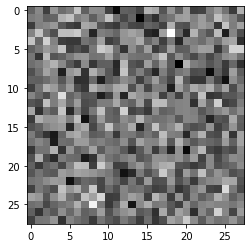

In [14]:
generator = G_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [15]:
def D_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = D_model()
pred = discriminator(generated_image)
print (pred)

tf.Tensor([[0.00485501]], shape=(1, 1), dtype=float32)


In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def d_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [19]:
def g_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
g_opt = tf.keras.optimizers.Adam(1e-4)
d_opt = tf.keras.optimizers.Adam(1e-4)

In [21]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = g_loss(fake_output)
        disc_loss = d_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss,disc_loss

In [23]:
def generate_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [24]:
def train(dataset, epochs):
    gen_loss = ''
    disc_loss = ''
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
    if (epoch + 1) % 15 == 0:
        generate_images(generator, epochs,seed)
    print ('Time for epoch {} is {} sec, gen_loss : {}, disc_loss : {}'.format(epoch + 1, time.time()-start, gen_loss, disc_loss))

    # 查看最后一个 epoch 生成图片
    generate_images(generator, epochs,seed)

Time for epoch 1 is 6.078127861022949 sec, gen_loss : 1.7815632820129395, disc_loss : 0.41754889488220215
Time for epoch 2 is 3.3016011714935303 sec, gen_loss : 3.472590446472168, disc_loss : 0.2166234254837036
Time for epoch 3 is 3.2557058334350586 sec, gen_loss : 3.4839365482330322, disc_loss : 0.2830563187599182
Time for epoch 4 is 3.253952980041504 sec, gen_loss : 2.3748481273651123, disc_loss : 0.4329875707626343
Time for epoch 5 is 3.2306363582611084 sec, gen_loss : 2.2542858123779297, disc_loss : 0.5042999982833862
Time for epoch 6 is 3.236438035964966 sec, gen_loss : 2.1893835067749023, disc_loss : 0.436332643032074
Time for epoch 7 is 3.2414987087249756 sec, gen_loss : 2.375523567199707, disc_loss : 0.43756067752838135
Time for epoch 8 is 3.2349092960357666 sec, gen_loss : 2.6871590614318848, disc_loss : 0.3019822835922241
Time for epoch 9 is 3.2365400791168213 sec, gen_loss : 2.5450003147125244, disc_loss : 0.3066079914569855
Time for epoch 10 is 3.2413227558135986 sec, gen_l

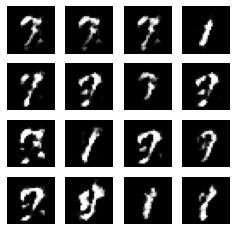

Time for epoch 15 is 3.7864603996276855 sec, gen_loss : 2.459294319152832, disc_loss : 0.4164888858795166
Time for epoch 16 is 3.244377613067627 sec, gen_loss : 2.503412961959839, disc_loss : 0.4178397059440613
Time for epoch 17 is 3.2396676540374756 sec, gen_loss : 2.133453845977783, disc_loss : 0.5603528022766113
Time for epoch 18 is 3.366434335708618 sec, gen_loss : 2.6320109367370605, disc_loss : 0.5673609972000122
Time for epoch 19 is 3.2405993938446045 sec, gen_loss : 2.110471248626709, disc_loss : 0.5328224301338196
Time for epoch 20 is 3.264214515686035 sec, gen_loss : 2.5405313968658447, disc_loss : 0.4001932740211487
Time for epoch 21 is 3.2393667697906494 sec, gen_loss : 2.1674864292144775, disc_loss : 0.6197875738143921
Time for epoch 22 is 3.2351927757263184 sec, gen_loss : 2.440004348754883, disc_loss : 0.5837827920913696
Time for epoch 23 is 3.252732753753662 sec, gen_loss : 2.003366470336914, disc_loss : 0.6098934412002563
Time for epoch 24 is 3.2676327228546143 sec, ge

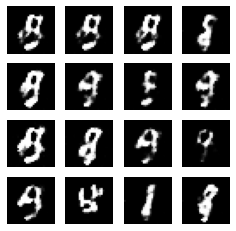

Time for epoch 30 is 3.7357289791107178 sec, gen_loss : 2.560891628265381, disc_loss : 0.4584023952484131
Time for epoch 31 is 3.2552602291107178 sec, gen_loss : 2.6158056259155273, disc_loss : 0.5488839149475098
Time for epoch 32 is 3.251455545425415 sec, gen_loss : 2.3378617763519287, disc_loss : 0.48657989501953125
Time for epoch 33 is 3.2374815940856934 sec, gen_loss : 2.4825150966644287, disc_loss : 0.5561115145683289
Time for epoch 34 is 3.241034507751465 sec, gen_loss : 2.6897590160369873, disc_loss : 0.4968932867050171
Time for epoch 35 is 3.2393198013305664 sec, gen_loss : 3.1722164154052734, disc_loss : 0.4902630150318146
Time for epoch 36 is 3.239917755126953 sec, gen_loss : 3.1380512714385986, disc_loss : 0.30940335988998413
Time for epoch 37 is 3.27390193939209 sec, gen_loss : 2.8447985649108887, disc_loss : 0.5050404071807861
Time for epoch 38 is 3.237436532974243 sec, gen_loss : 2.7740328311920166, disc_loss : 0.5700175166130066
Time for epoch 39 is 3.2323639392852783 se

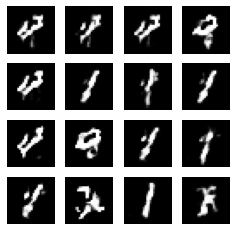

Time for epoch 45 is 3.73120379447937 sec, gen_loss : 2.3813154697418213, disc_loss : 0.4459693133831024
Time for epoch 46 is 3.265408754348755 sec, gen_loss : 2.6553471088409424, disc_loss : 0.5487583875656128
Time for epoch 47 is 3.2401208877563477 sec, gen_loss : 3.155632495880127, disc_loss : 0.38368362188339233
Time for epoch 48 is 3.2350261211395264 sec, gen_loss : 2.594254732131958, disc_loss : 0.6058213114738464
Time for epoch 49 is 3.2457058429718018 sec, gen_loss : 2.633925676345825, disc_loss : 0.4667700231075287
Time for epoch 50 is 3.2353620529174805 sec, gen_loss : 2.676754951477051, disc_loss : 0.37458154559135437


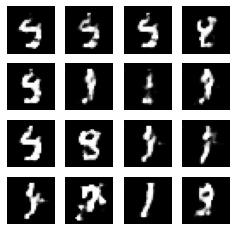

CPU times: user 1min 39s, sys: 11.6 s, total: 1min 51s
Wall time: 2min 47s


In [25]:
%%time
train(train_dataset, 50)

Time for epoch 1 is 3.258030414581299 sec, gen_loss : 2.3117470741271973, disc_loss : 0.420110285282135
Time for epoch 2 is 3.2347373962402344 sec, gen_loss : 3.0551743507385254, disc_loss : 0.6009182929992676
Time for epoch 3 is 3.238480806350708 sec, gen_loss : 2.369655132293701, disc_loss : 0.595041811466217
Time for epoch 4 is 3.2517364025115967 sec, gen_loss : 2.9713101387023926, disc_loss : 0.5465674996376038
Time for epoch 5 is 3.2513058185577393 sec, gen_loss : 2.780277729034424, disc_loss : 0.4034122824668884
Time for epoch 6 is 3.236354112625122 sec, gen_loss : 2.5527825355529785, disc_loss : 0.40102988481521606
Time for epoch 7 is 3.2413997650146484 sec, gen_loss : 2.868837356567383, disc_loss : 0.48614072799682617
Time for epoch 8 is 3.237433671951294 sec, gen_loss : 2.518909454345703, disc_loss : 0.5482388734817505
Time for epoch 9 is 3.2491536140441895 sec, gen_loss : 2.723388195037842, disc_loss : 0.38829055428504944
Time for epoch 10 is 3.2344741821289062 sec, gen_loss 

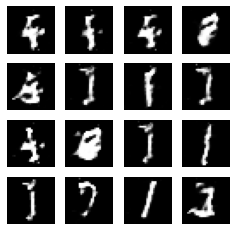

Time for epoch 15 is 3.7418429851531982 sec, gen_loss : 3.0604796409606934, disc_loss : 0.6501601934432983
Time for epoch 16 is 3.2539474964141846 sec, gen_loss : 2.276733875274658, disc_loss : 0.4335062503814697
Time for epoch 17 is 3.236039161682129 sec, gen_loss : 2.54042911529541, disc_loss : 0.5297296047210693
Time for epoch 18 is 3.2356441020965576 sec, gen_loss : 2.1131062507629395, disc_loss : 0.5458894371986389
Time for epoch 19 is 3.2480809688568115 sec, gen_loss : 2.058460235595703, disc_loss : 0.6958683729171753
Time for epoch 20 is 3.241201639175415 sec, gen_loss : 1.7228032350540161, disc_loss : 0.7523354887962341
Time for epoch 21 is 3.245936632156372 sec, gen_loss : 2.5253653526306152, disc_loss : 0.43233558535575867
Time for epoch 22 is 3.2410967350006104 sec, gen_loss : 2.4697728157043457, disc_loss : 0.595226526260376
Time for epoch 23 is 3.2391645908355713 sec, gen_loss : 2.311918020248413, disc_loss : 0.6810451149940491
Time for epoch 24 is 3.243906021118164 sec, g

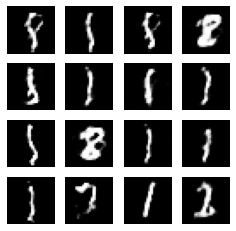

Time for epoch 30 is 3.7542450428009033 sec, gen_loss : 2.003951072692871, disc_loss : 0.5157309770584106
Time for epoch 31 is 3.2418785095214844 sec, gen_loss : 2.3067433834075928, disc_loss : 0.6387526988983154
Time for epoch 32 is 3.2424685955047607 sec, gen_loss : 2.1396214962005615, disc_loss : 0.769800066947937
Time for epoch 33 is 3.2539186477661133 sec, gen_loss : 2.23960018157959, disc_loss : 0.6510165929794312
Time for epoch 34 is 3.251739978790283 sec, gen_loss : 2.154069662094116, disc_loss : 0.5035097599029541
Time for epoch 35 is 3.2479910850524902 sec, gen_loss : 2.2619004249572754, disc_loss : 0.6628931760787964
Time for epoch 36 is 3.2393648624420166 sec, gen_loss : 2.1060194969177246, disc_loss : 0.8382479548454285
Time for epoch 37 is 3.233139753341675 sec, gen_loss : 2.2125654220581055, disc_loss : 0.6852685213088989
Time for epoch 38 is 3.245203733444214 sec, gen_loss : 2.2547757625579834, disc_loss : 0.7362232804298401
Time for epoch 39 is 3.2670252323150635 sec, 

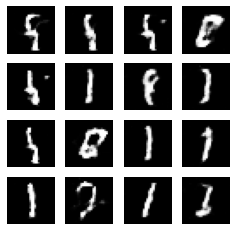

Time for epoch 45 is 3.9099209308624268 sec, gen_loss : 1.8331501483917236, disc_loss : 0.5329799652099609
Time for epoch 46 is 3.240452527999878 sec, gen_loss : 2.0033559799194336, disc_loss : 0.5132718682289124
Time for epoch 47 is 3.246044874191284 sec, gen_loss : 2.05491304397583, disc_loss : 0.7691808938980103
Time for epoch 48 is 3.2377490997314453 sec, gen_loss : 1.8961811065673828, disc_loss : 0.6335349082946777
Time for epoch 49 is 3.2380950450897217 sec, gen_loss : 2.874417304992676, disc_loss : 0.6704259514808655
Time for epoch 50 is 3.2448203563690186 sec, gen_loss : 2.1966090202331543, disc_loss : 0.5856109857559204
Time for epoch 51 is 3.238853693008423 sec, gen_loss : 1.986816167831421, disc_loss : 0.652506947517395
Time for epoch 52 is 3.2586307525634766 sec, gen_loss : 1.8260200023651123, disc_loss : 0.7022397518157959
Time for epoch 53 is 3.2461612224578857 sec, gen_loss : 2.3903050422668457, disc_loss : 0.6485733985900879
Time for epoch 54 is 3.239117383956909 sec, g

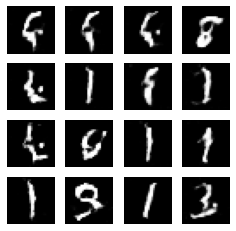

Time for epoch 60 is 3.757214069366455 sec, gen_loss : 2.012207508087158, disc_loss : 0.6292879581451416
Time for epoch 61 is 3.259556531906128 sec, gen_loss : 2.012974500656128, disc_loss : 0.6628071069717407
Time for epoch 62 is 3.2522788047790527 sec, gen_loss : 1.5973669290542603, disc_loss : 0.7223191261291504
Time for epoch 63 is 3.2398862838745117 sec, gen_loss : 2.014249563217163, disc_loss : 0.5058116912841797
Time for epoch 64 is 3.237133264541626 sec, gen_loss : 1.9643441438674927, disc_loss : 0.6093596816062927
Time for epoch 65 is 3.2437453269958496 sec, gen_loss : 1.7580114603042603, disc_loss : 0.8957253694534302
Time for epoch 66 is 3.238208532333374 sec, gen_loss : 1.5544534921646118, disc_loss : 0.7244167327880859
Time for epoch 67 is 3.2511465549468994 sec, gen_loss : 1.779797911643982, disc_loss : 0.7376046180725098
Time for epoch 68 is 3.2362797260284424 sec, gen_loss : 1.7748920917510986, disc_loss : 0.6558022499084473
Time for epoch 69 is 3.240196943283081 sec, g

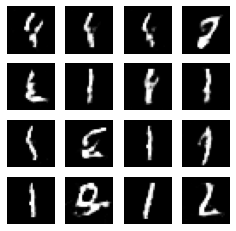

Time for epoch 75 is 3.7123892307281494 sec, gen_loss : 2.0126914978027344, disc_loss : 0.8364150524139404
Time for epoch 76 is 3.248595952987671 sec, gen_loss : 2.0131278038024902, disc_loss : 0.6844732761383057
Time for epoch 77 is 3.238793134689331 sec, gen_loss : 2.0392675399780273, disc_loss : 0.7281234264373779
Time for epoch 78 is 3.2370405197143555 sec, gen_loss : 1.821293592453003, disc_loss : 0.7033183574676514
Time for epoch 79 is 3.2477688789367676 sec, gen_loss : 1.6890785694122314, disc_loss : 0.8577589392662048
Time for epoch 80 is 3.2399606704711914 sec, gen_loss : 1.8044394254684448, disc_loss : 0.5832656621932983
Time for epoch 81 is 3.2486934661865234 sec, gen_loss : 2.199601173400879, disc_loss : 0.7725189924240112
Time for epoch 82 is 3.241940975189209 sec, gen_loss : 1.9809727668762207, disc_loss : 0.6308943033218384
Time for epoch 83 is 3.2304904460906982 sec, gen_loss : 1.8424642086029053, disc_loss : 0.7867496013641357
Time for epoch 84 is 3.2423510551452637 se

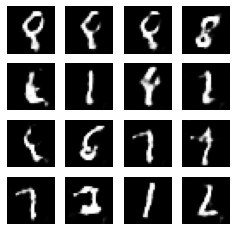

Time for epoch 90 is 3.8782296180725098 sec, gen_loss : 1.9952870607376099, disc_loss : 0.7484500408172607
Time for epoch 91 is 3.250598907470703 sec, gen_loss : 2.1650946140289307, disc_loss : 0.6660611033439636
Time for epoch 92 is 3.2416157722473145 sec, gen_loss : 1.9512786865234375, disc_loss : 0.6435160636901855
Time for epoch 93 is 3.2346177101135254 sec, gen_loss : 1.5841131210327148, disc_loss : 0.71402508020401
Time for epoch 94 is 3.233042001724243 sec, gen_loss : 1.887536883354187, disc_loss : 0.6552202701568604
Time for epoch 95 is 3.2430765628814697 sec, gen_loss : 1.744871973991394, disc_loss : 0.6979396343231201
Time for epoch 96 is 3.2571566104888916 sec, gen_loss : 2.1517693996429443, disc_loss : 0.7665054798126221
Time for epoch 97 is 3.234644889831543 sec, gen_loss : 1.9984092712402344, disc_loss : 0.8056061267852783
Time for epoch 98 is 3.242846727371216 sec, gen_loss : 1.9788222312927246, disc_loss : 0.7705097794532776
Time for epoch 99 is 3.237746000289917 sec, g

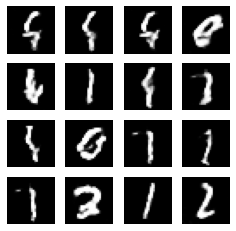

CPU times: user 3min 13s, sys: 23.2 s, total: 3min 36s
Wall time: 5min 28s


In [26]:
%%time
train(train_dataset, 100)